# IT-Skills for Research

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Sun Nov 20 16:18:28 2022

@author: angelDu @RB
"""
#%%
### Download necessary libraries
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import datetime 
from pandas.tseries.offsets import BDay
import matplotlib.pyplot as plt 


# Specifying variables
path = r"C:\Users\angel\Final--crypto\data"
#path= "/Users/julianfischer/projects/Final--crypto/data"


# Defining functions
def loadData(path):
    #cryptoPrices = pd.read_excel(path + '\CommonAssetClassesPrices.xlsx')
    equityPrices = pd.read_excel(path + '\Equities.xlsx')
    bondPrices = pd.read_excel(path + '\Bonds.xlsx')
    cmdtyPrices = pd.read_excel(path + '\Commodities.xlsx')
    vixPrices = pd.read_excel(path + '\VIX.xlsx')
    cryptoPrices = pd.read_excel(path + '\crypto-prices.xlsx')
    cryptoPrices['Dates'] = pd.to_datetime(cryptoPrices['Dates'])
    cryptoPrices.columns = ['Dates', 'BTC', 'ETH', 'XRP', 'XLM']
    
    return equityPrices, bondPrices, cmdtyPrices, vixPrices, cryptoPrices

def loadData_forcoolguys(path):
    #cryptoPrices = pd.read_excel(path + '\CommonAssetClassesPrices.xlsx')
    equityPrices = pd.read_excel(path + '/Equities.xlsx')
    bondPrices = pd.read_excel(path + '/Bonds.xlsx')
    cmdtyPrices = pd.read_excel(path + '/Commodities.xlsx')
    vixPrices = pd.read_excel(path + '/VIX.xlsx')
    cryptoPrices = pd.read_excel(path + '/crypto-prices.xlsx')
    cryptoPrices['Dates'] = pd.to_datetime(cryptoPrices['Dates'])
    cryptoPrices.columns = ['Dates', 'BTC', 'ETH', 'XRP', 'XLM']
    
    return equityPrices, bondPrices, cmdtyPrices, vixPrices, cryptoPrices

def getStartEnd(*data):
    minDate = datetime.datetime.strptime("30/11/0001","%d/%m/%Y")
    maxDate = datetime.datetime.strptime("30/11/3000","%d/%m/%Y")
    for d in data: 
        end = d['Dates'].iat[-1]
        start = d['Dates'][0]
        
        if end<maxDate:
            maxDate = end
            
        if start>minDate:
            minDate = start
            
    return minDate, maxDate
    
            
def makeDataUniformLength(start, end, assetList, *data):
    cnt = 0
    #aggData = []
    aggData = {}
    for d in data:
        d = d[(d['Dates']>=start)&(d['Dates']<=end)]
        #aggData.append([d])
        aggData[assetList[cnt]] = d
        cnt+=1
    
    return aggData

def mergeDataFrames(dictDf, assetList):
    merged = dictDf[assetList[0]]
    
    for i in range(len(assetList)):
        if i == len(assetList)-1:
            break
        merged = pd.merge(merged, dictDf[assetList[i+1]], on = ['Dates'])

    return merged 

def getBusinessDaysOnly(df):
    isBusinessDay = BDay().onOffset
    #isBusinessDay = BDay().is_on_offset()
    match_series = pd.to_datetime(df['Dates']).map(isBusinessDay)
    return df[match_series]

def calcDailyReturn(price):
    rets = price.pct_change(1)
    
    
    return rets

def getCorr(df1,df2):
    corr, _ = pearsonr(df1, df2)
    return corr
    
    
#def plotRelationship(df1,df2):
# Importing data
assetNamesList = ['equity', 'bond', 'commodity', 'vix', 'crypto']

equity, bond, cmdty, vix, crypto = loadData(path) 
start, end = getStartEnd(equity, bond, cmdty, vix, crypto)
allData = makeDataUniformLength(start, end, assetNamesList, equity, bond, cmdty, vix, crypto)
mergedData = mergeDataFrames(allData, assetNamesList)


#weeklyData = mergedData.loc[mergedData.groupby(mergedData.index.to_period('W')).apply(lambda x: x.index.max())]



# Calculating returns
dailyRets = {}
for a in assetNamesList:
    dailyRets[a] = calcDailyReturn(allData[a].iloc[:,1:])

mergedDailyRets = calcDailyReturn(mergedData.iloc[:,1:])
mergedDailyRets.index = mergedData.Dates


In [3]:
rets = mergedData.iloc[:,1:].pct_change(1)
dataProblem = mergedData.iloc[:19,7] 

for d in range(len(dataProblem.values)):
    if d == len(dataProblem.values)-1:
        break
    old = dataProblem.values[d]
    new = dataProblem.values[d+1]
    
    if (old<0 and new<0) or (old<0 and new>=0) or (old>0 and new<=0):
        rets.iloc[d+1,6] = 1 - new/old
        
    elif old == 0 and new == 0:
        rets.iloc[d+1,6] = 0
        
    elif old == 0 and new > 0:
        rets.iloc[d+1,6] = 1
        
    else:
        rets.iloc[d+1,6] = -1
        
mergedDailyRets.iloc[1:19,6] = rets.iloc[1:19,6] 


In [58]:
#Replace mergedDailyRets with -100% change to -100.0001% so that cumprod() doesn't return 0
#mergedDailyRets.replace(-1,-1.000001, inplace=True)

In [4]:
# Specify different time periods
mergedDailyRets_Covid = mergedDailyRets.iloc[1071:1576,:]
mergedDailyRets_Covid_short = mergedDailyRets.iloc[1071:1324,:]
mergedDailyRets_Covid_today = mergedDailyRets.iloc[1071:,:]

In [5]:
Index_names = mergedData.columns
Index_names


Index(['Dates', 'Hang Seng', 'NASDAQ', 'Stoxx 50', 'Nikkei', 'S&P500', 'GILTS',
       'US 3m Treasury', 'US 5YR Treasury', 'US 10YR Treasury', 'Euro 10y',
       'Japan 10y', 'Corn', 'Wheat', 'Coffee', 'Soybean', 'Cotton', 'Gold',
       'Silver', 'Copper', 'Platinum', 'Crude', 'Nat. gas', 'Liver cattle',
       'VIX Index', 'BTC', 'ETH', 'XRP', 'XLM'],
      dtype='object')

In [62]:
#mergedDailyRets.to_excel(path + '/test.xlsx')

#### (mergedDailyRets["US 3m Treasury"])


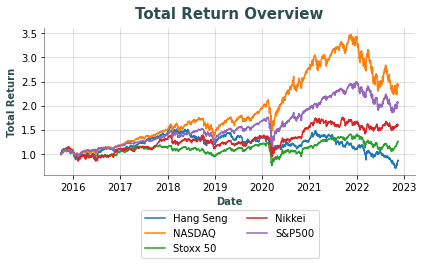

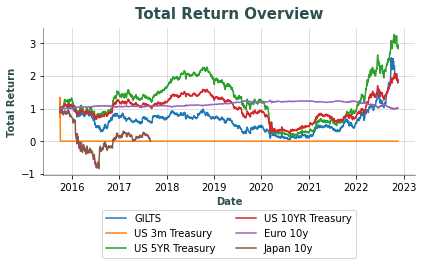

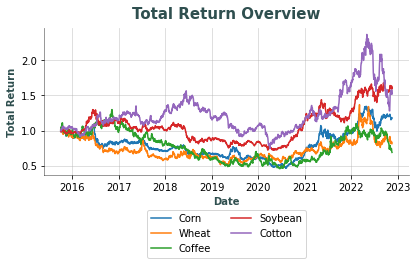

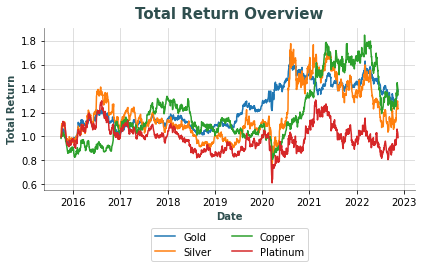

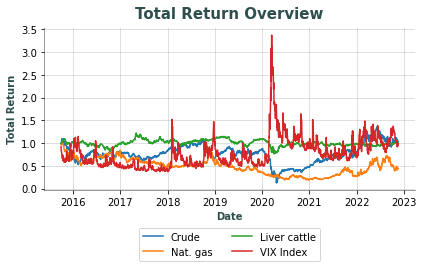

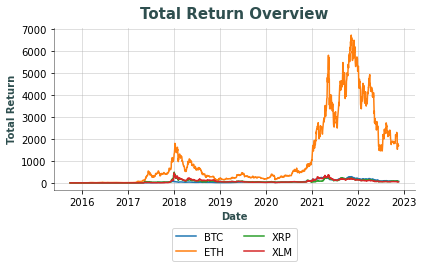

In [6]:
# EDA, plot some returns
totalRet = (mergedDailyRets+1).cumprod()
totalRet_Covid = (mergedDailyRets_Covid+1).cumprod()
totalRet_Covid_short = (mergedDailyRets_Covid_short+1).cumprod()
totalRet_Covid_today = (mergedDailyRets_Covid_today+1).cumprod()


#Plot them, Cryptos separately due to different scale
plotPath = r'C:\Users\angel\Final--crypto\reports\figures'
graphNames = ['Equities', 'Bonds', 'Agriculture', 'Precious metals', 'Other', 'Crypto']
k=[1,6,12,17,21,25,len(Index_names)]
h=0
for j in range(len(k)-1):
    h+=1
    fig, ax = plt.subplots(1,1)
    for i in Index_names[k[h-1]:k[h]]:
        ax.plot(totalRet[i], label="{}".format(i))
        
    ax.set_xlabel("Date", fontweight="demi", c="darkslategray")
    ax.set_ylabel("Total Return", fontweight="demi", c="darkslategray")
    ax.set_title("Total Return Overview",fontsize=15, y=1.02, c="darkslategray", fontweight="bold")
    ax.legend(loc='upper center',bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=False, ncol=2)
    #plt.xticks(rotation=70)
    plt.gca().spines["top"].set_alpha(0.0)    
    plt.gca().spines["bottom"].set_alpha(0.5)
    plt.gca().spines["right"].set_alpha(0.0)    
    plt.gca().spines["left"].set_alpha(0.5) 
    plt.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.savefig(plotPath + '\%s.png'%graphNames[j])
    


<ipython-input-8-7ed6a6c2f099>:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(mergedDailyRets.corr(), dtype=np.bool))
<ipython-input-8-7ed6a6c2f099>:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(mergedDailyRets[Index_names[k[h-1]:k[h]]].corr(), dtype=np.bool))


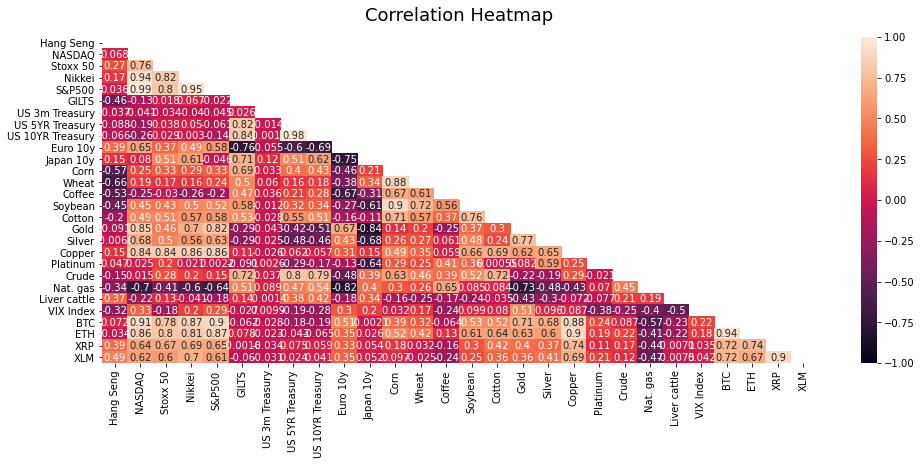

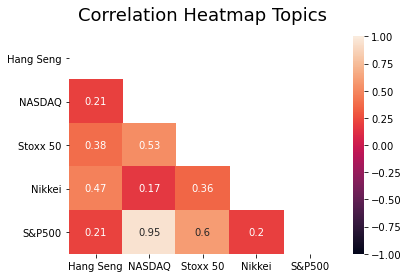

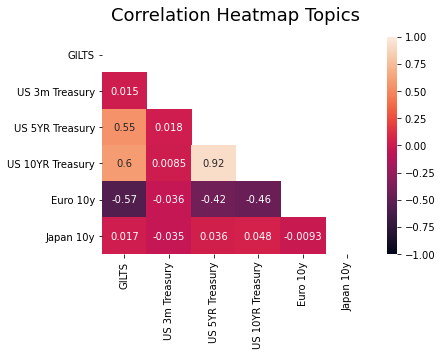

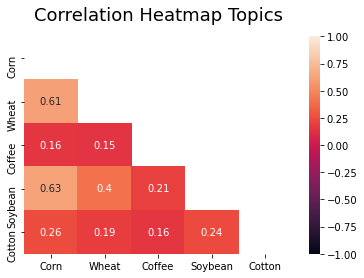

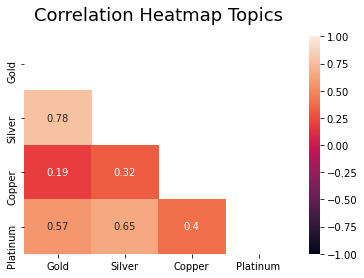

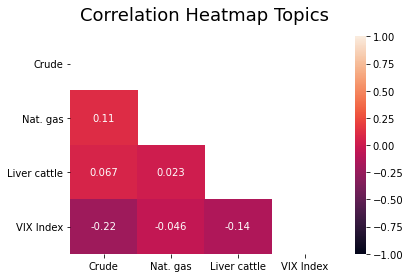

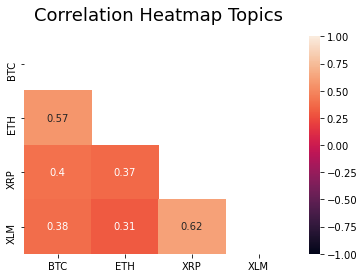

In [8]:
#Calc some correlations
import seaborn as sns
#sns.heatmap(totalRet.corr());

plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(mergedDailyRets.corr(), dtype=np.bool))

heatmap = sns.heatmap(totalRet.corr(), mask=mask, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16)

plt.savefig(plotPath + '\corrHeatmap.png')

k=[1,6,12,17,21,25,len(Index_names)]
h=0
for j in range(len(k)-1):
    h+=1
    fig, ax = plt.subplots(1,1)
    mask = np.triu(np.ones_like(mergedDailyRets[Index_names[k[h-1]:k[h]]].corr(), dtype=np.bool))
    heatmap = sns.heatmap(mergedDailyRets[Index_names[k[h-1]:k[h]]].corr(), mask=mask, vmin=-1, vmax=1, annot=True)
    heatmap.set_title('Correlation Heatmap Topics', fontdict={'fontsize':18}, pad=16)
    plt.savefig(plotPath + '\corrHeatmap_%s.png'%graphNames[j])


<ipython-input-7-73f89f1f47c6>:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(mergedDailyRets.corr(), dtype=np.bool))
<ipython-input-7-73f89f1f47c6>:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(mergedDailyRets[Index_names[k[h-1]:k[h]]].corr(), dtype=np.bool))


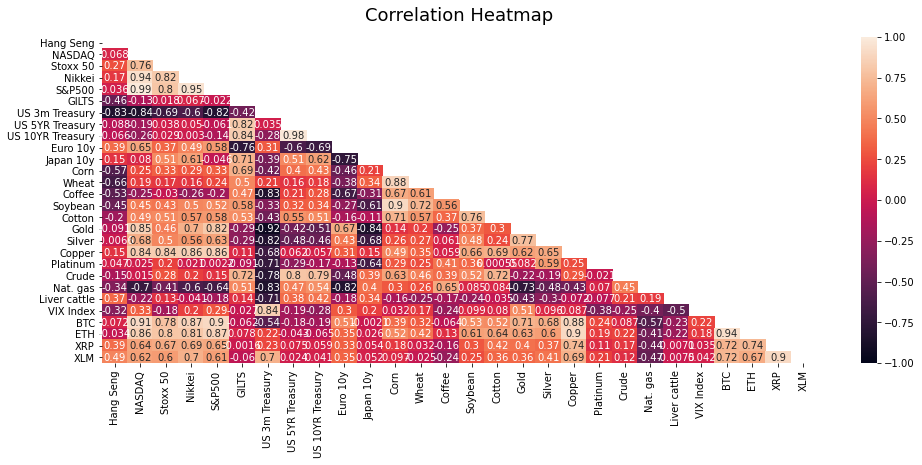

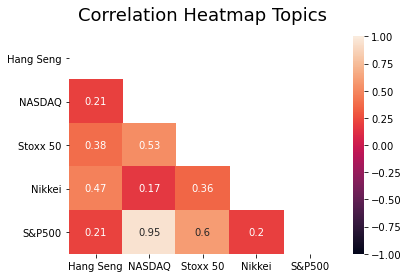

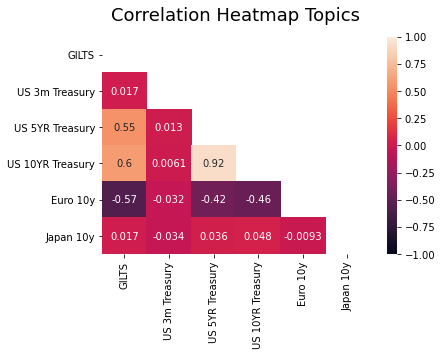

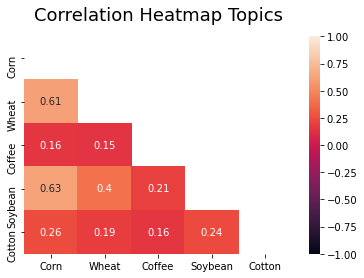

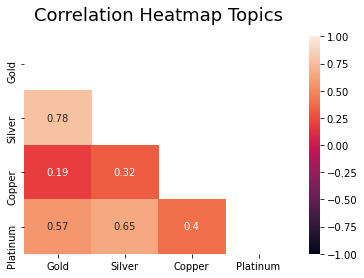

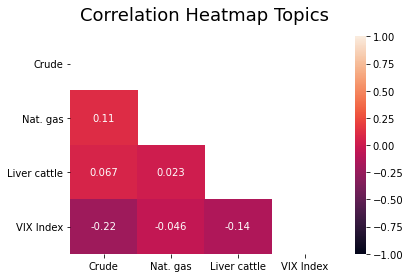

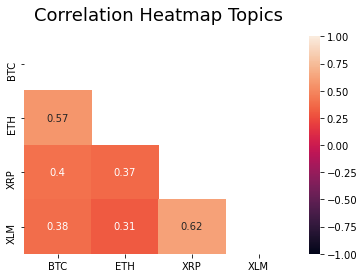

In [7]:
# Calculate some corr for Covid period



plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(mergedDailyRets.corr(), dtype=np.bool))
heatmap = sns.heatmap(totalRet.corr(), mask=mask, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16)

k=[1,6,12,17,21,25,len(Index_names)]
h=0
for j in range(len(k)-1):
    h+=1
    fig, ax = plt.subplots(1,1)
    mask = np.triu(np.ones_like(mergedDailyRets[Index_names[k[h-1]:k[h]]].corr(), dtype=np.bool))
    heatmap = sns.heatmap(mergedDailyRets[Index_names[k[h-1]:k[h]]].corr(), mask=mask, vmin=-1, vmax=1, annot=True)
    heatmap.set_title('Correlation Heatmap Topics', fontdict={'fontsize':18}, pad=16)



In [152]:
"""
Would be interesting to focus on NASDAQ for example and find the best hedging instrument --> Coffee?

or generally check what would work well.."""

'\nWould be interesting to focus on NASDAQ for example and find the best hedging instrument --> Coffee?\n\nor generally check what would work well..'

Table of p-values from the Granger Causality Test:
+------------+-------+
| btc_natgas | 0.353 |
| eth_natgas | 0.496 |
| xrp_natgas | 0.15  |
| xlm_natgas | 0.688 |
+------------+-------+


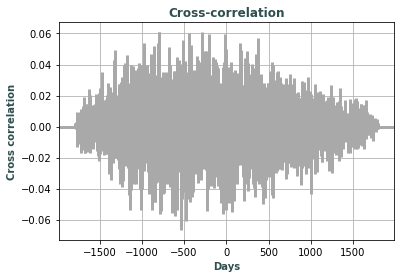

The maximal correlation is obtained 
  by shifting the index -799 days. (to the right if the number is positive.) 



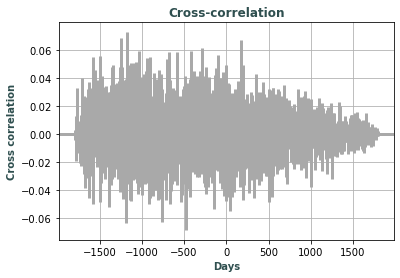

The maximal correlation is obtained 
  by shifting the index -1170 days. (to the right if the number is positive.) 



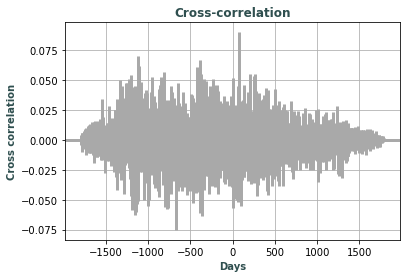

The maximal correlation is obtained 
  by shifting the index 79 days. (to the right if the number is positive.) 



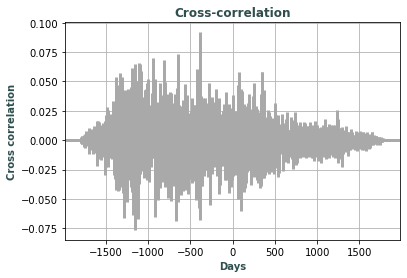

The maximal correlation is obtained 
  by shifting the index -385 days. (to the right if the number is positive.) 



In [65]:
from statsmodels.tsa.stattools import grangercausalitytests
from tabulate import tabulate
from scipy import signal

def get_grframe(grtest):
    #Returns a dataframe with the p-value of the ssr_chi2test
    grlist = []
    for i in range(1,maxlag):
        grlist.append(grtest[i][0]["ssr_chi2test"][1])
    grframe = pd.DataFrame(grlist, np.arange(1,maxlag), columns=['p-value'])
    grframe.index.name = "Number of lags"
    
    return grframe

maxlag= 30

def getpvals(asset1, asset2, returns, maxlag):
    df = pd.DataFrame([returns[asset1],returns[asset2]]).iloc[:,-returns.shape[0]+1:].T
    gtest = grangercausalitytests(df, maxlag, verbose=False)
    return get_grframe(gtest), df

## Create df according to requirements
#df_nasdaq_stoxx = pd.DataFrame([mergedDailyRets["NASDAQ"],mergedDailyRets["Stoxx 50"]]).iloc[:,-mergedDailyRets.shape[0]+1:].T
#df_nasdaq_nikkei = pd.DataFrame([mergedDailyRets["NASDAQ"],mergedDailyRets["Nikkei"]]).iloc[:,-mergedDailyRets.shape[0]+1:].T
#df_vix_nasdaq = pd.DataFrame([mergedDailyRets["VIX Index"],mergedDailyRets["NASDAQ"]]).iloc[:,-mergedDailyRets.shape[0]+1:].T
#df_nasdaq_coffee = pd.DataFrame([mergedDailyRets["NASDAQ"],mergedDailyRets["Coffee"]]).iloc[:,-mergedDailyRets.shape[0]+1:].T


## G-Testing
#gtest_nasdaq_stoxx = grangercausalitytests(df_nasdaq_stoxx, maxlag, verbose=False)
#gtest_nasdaq_nikkei = grangercausalitytests(df_nasdaq_nikkei, maxlag, verbose=False)
#gtest_vix_nasdaq = grangercausalitytests(df_vix_nasdaq, maxlag, verbose=False)
#gtest_nasdaq_coffee = grangercausalitytests(df_nasdaq_coffee, maxlag, verbose=False)


#pvalues_gtest_nasdaq_stoxx = get_grframe(gtest_nasdaq_stoxx)
#pvalues_gtest_nasdaq_nikkei = get_grframe(gtest_nasdaq_nikkei)
#pvalues_gtest_vix_nasdaq = get_grframe(gtest_vix_nasdaq)
#pvalues_gtest_nasdaq_coffee = get_grframe(gtest_nasdaq_coffee)

pvalues_gtest_BTC_natgas, df_BTC_natgas = getpvals("BTC", "Nat. gas", mergedDailyRets, maxlag)
pvalues_gtest_ETH_natgas, df_ETH_natgas = getpvals("ETH", "Nat. gas", mergedDailyRets, maxlag)
pvalues_gtest_XRP_natgas, df_XRP_natgas = getpvals("XRP", "Nat. gas", mergedDailyRets, maxlag)
pvalues_gtest_XLM_natgas, df_XLM_natgas = getpvals("XLM", "Nat. gas", mergedDailyRets, maxlag)






mean_pvalue_table = pd.DataFrame([np.mean(pvalues_gtest_BTC_natgas),np.mean(pvalues_gtest_ETH_natgas), np.mean(pvalues_gtest_XRP_natgas), np.mean(pvalues_gtest_XLM_natgas)])
mean_pvalue_table.columns = ["Mean p-value"]
mean_pvalue_table.index = ["btc_natgas", "eth_natgas", "xrp_natgas","xlm_natgas"]


print("Table of p-values from the Granger Causality Test:")
print(tabulate(round(mean_pvalue_table,3), tablefmt='psql'))

# the null hypothesis would be: X does not granger cause Y or the other way. Also, you accept or reject your null hypothesis depending on the level of significance.
# if P value < Significance level, then Null hypothesis would be rejected.
# if P value > Significance level, then Null hypothesis cannot be rejected.


def crosscorr_plot(data, a, col1, col2, new=False):
    
    fig, ax1 = plt.subplots(1, 1, sharex=True)
    if new==True:
        ax1.xcorr(data[col1], data[col2], usevlines=True, maxlags=len(data[col1])-1,normed=True, lw=3, color="darkgrey")
        ax1.set_title("Cross-correlation",color="darkslategray",fontsize=12, fontweight="bold")
        temp = signal.correlate(data[col1], data[col2])
        shift = len(data[col1])-1

    else:
        
        ax1.xcorr(data[col1], data[col2], usevlines=True, maxlags=len(data[col1])-1,normed=True, lw=3, color="darkgrey")
        ax1.set_title("Cross-correlation",color="darkslategray",fontsize=12, fontweight="bold")
        temp = signal.correlate(data[col1], data[col2])
        shift = len(data[col1])-1

    ax1.grid(True)
    temp2 = int(np.where(temp == max(temp))[0])
    #or temp2 = np.argmax(temp)
    ax1.set_xlabel('Days',color="darkslategray",fontsize=10, fontweight="demi")
    ax1.set_ylabel('Cross correlation',color="darkslategray",fontsize=10, fontweight="demi")
    plt.show()
    print("The maximal correlation is obtained","\n"," by shifting the index",temp2-shift, "days. (to the right if the number is positive.)", "\n")
    return (temp2-shift)


lags_btc_natgas = crosscorr_plot(df_BTC_natgas, 1, "BTC", "Nat. gas")
lags_eth_natgas = crosscorr_plot(df_ETH_natgas, 1, "ETH", "Nat. gas")
lags_xrp_natgas = crosscorr_plot(df_XRP_natgas, 1, "XRP", "Nat. gas")
lags_xlm_natgas = crosscorr_plot(df_XLM_natgas, 1, "XLM", "Nat. gas")



In [66]:
#hedge_nasdaq_with_coffee = (((mergedDailyRets["NASDAQ"]+mergedDailyRets["Coffee"])/2)+1).cumprod()
hedge_btc_with_natgas = (((mergedDailyRets["BTC"]+mergedDailyRets["Nat. gas"])/2)+1).cumprod()

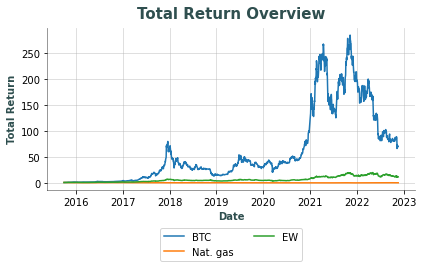

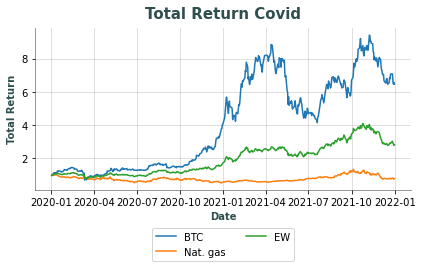

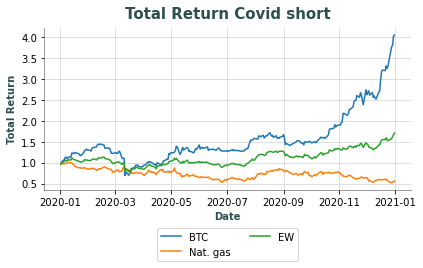

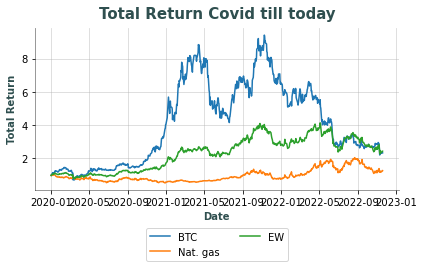

In [67]:
# Just wondering if coffee can hedge nasdaq (Covid and total time window)
Strat_Nasdaq_Coffee = (((mergedDailyRets["BTC"]+mergedDailyRets["Nat. gas"])/2)+1).cumprod()
Strat_Nasdaq_Coffee_Covid = (((mergedDailyRets_Covid["BTC"]+mergedDailyRets_Covid["Nat. gas"])/2)+1).cumprod()
Strat_Nasdaq_Coffee_Covid_short = (((mergedDailyRets_Covid_short["BTC"]+mergedDailyRets_Covid_short["Nat. gas"])/2)+1).cumprod()
Strat_Nasdaq_Coffee_Covid_today = (((mergedDailyRets_Covid_today["BTC"]+mergedDailyRets_Covid_today["Nat. gas"])/2)+1).cumprod()


def plot_three(data1,data2,data3,labels,ylabel,xlabel,title):
    fig, ax = plt.subplots(1,1)
    ax.plot(data1, label=labels[0])
    ax.plot(data2, label=labels[1])
    ax.plot(data3, label=labels[2])
    ax.set_xlabel(xlabel, fontweight="demi", c="darkslategray")
    ax.set_ylabel(ylabel, fontweight="demi", c="darkslategray")
    ax.set_title(title,fontsize=15, y=1.02, c="darkslategray", fontweight="bold")
    ax.legend(loc='upper center',bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=False, ncol=2)
    #plt.xticks(rotation=70)
    plt.gca().spines["top"].set_alpha(0.0)    
    plt.gca().spines["bottom"].set_alpha(0.5)
    plt.gca().spines["right"].set_alpha(0.0)    
    plt.gca().spines["left"].set_alpha(0.5) 
    plt.grid(True, alpha=0.5)
    plt.tight_layout()

plot_three(totalRet["BTC"],totalRet["Nat. gas"],Strat_Nasdaq_Coffee,["BTC","Nat. gas", "EW"],"Total Return","Date","Total Return Overview")
plot_three(totalRet_Covid["BTC"],totalRet_Covid["Nat. gas"],Strat_Nasdaq_Coffee_Covid,["BTC","Nat. gas", "EW"],"Total Return","Date","Total Return Covid")
plot_three(totalRet_Covid_short["BTC"],totalRet_Covid_short["Nat. gas"],Strat_Nasdaq_Coffee_Covid_short,["BTC","Nat. gas", "EW"],"Total Return","Date","Total Return Covid short")
plot_three(totalRet_Covid_today["BTC"],totalRet_Covid_today["Nat. gas"],Strat_Nasdaq_Coffee_Covid_today,["BTC","Nat. gas", "EW"],"Total Return","Date","Total Return Covid till today")

